#### Library import

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

from matplotlib.ticker import FormatStrFormatter

from tensorflow import keras

import re
from tqdm import tqdm

#### GPU setting

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [3]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = InteractiveSession(config = config)

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11535176595722398888
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3435973836
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13588110214029909939
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


In [5]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

#### Data import and preprocessing

In [269]:
data = pd.read_csv("data/data.csv")
data.columns

Index(['OBJECTID_x', 'ID', 'pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope',
       'altitude', 'profile_curve', 'profile_c_num', 'profile_c_abs',
       'planform_curve', 'planform_c_num', 'planform_c_abs', 'HYDGRP',
       'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C', 'HYDGRP_D', 'ANION_EXCL', 'SOL_CRK',
       'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'SOL_EC1', 'distance'],
      dtype='object')

In [270]:
data = data.drop(['OBJECTID_x','ID','HYDGRP','profile_c_num', 'profile_c_abs','planform_c_num', 'planform_c_abs','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)
data.columns

Index(['pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope', 'altitude',
       'profile_curve', 'planform_curve', 'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C',
       'HYDGRP_D', 'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'distance'],
      dtype='object')

In [271]:
As = data
Cd = data
Ni = data

In [272]:
As = As.drop(["Cd", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Cd = Cd.drop(["As", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Ni = Ni.drop(["As", "Cd", "Pb", "Zn", "Hg"], axis = 1)

#### Oversampling by SMOGN (SMOTE Regression)

In [273]:
import smogn

In [274]:
As_smogn = smogn.smoter(data = As, y = 'As', samp_method = 'extreme')
Cd_smogn = smogn.smoter(data = Cd, y = 'Cd', samp_method = 'extreme')
Ni_smogn = smogn.smoter(data = Ni, y = 'Ni', samp_method = 'extreme')


synth_matrix: 100%|##########| 242/242 [00:01<00:00, 155.29it/s]


#### Eliminate outlier and train / test split

In [275]:
def eli_outlier(data, value):
    q1 = data[value].quantile(0.25)
    q3 = data[value].quantile(0.75)

    iqr = q3 - q1

    q1_condition = data[value] < q1-1.5*iqr
    q3_condition = data[value] > q3+1.5*iqr

    reset_q1_index = data[q1_condition].index
    reset_q3_index = data[q3_condition].index

    data.drop(reset_q1_index, inplace = True)
    data.drop(reset_q3_index, inplace = True)

    return data

In [276]:
As_ros = eli_outlier(As_smogn, "As")
Cd_ros = eli_outlier(Cd_smogn, "Cd")
Ni_ros = eli_outlier(Ni_smogn, "Ni")

In [277]:
As_X = As_ros.drop(["As"], axis=1)
Cd_X = Cd_ros.drop(["Cd"], axis=1)
Ni_X = Ni_ros.drop(["Ni"], axis=1)

As_y = As_ros["As"]
Cd_y = Cd_ros["Cd"]
Ni_y = Ni_ros["Ni"]

In [278]:
As_y = np.log1p(As_ros["As"])
Cd_y = np.log1p(Cd_ros["Cd"])
Ni_y = np.log1p(Ni_ros["Ni"])

In [279]:
print(As_X.shape)
print(Cd_X.shape)
print(Ni_X.shape)

(1660, 15)
(1781, 15)
(2073, 15)


#### Over Sampling

StandardScaler

In [280]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
As_X_scaled = scaler.fit_transform(As_X)
Cd_X_scaled = scaler.fit_transform(Cd_X)
Ni_X_scaled = scaler.fit_transform(Ni_X)

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

MinMaxScaler

In [11]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# As_X_scaled = scaler.fit_transform(As_X)
# Cd_X_scaled = scaler.fit_transform(Cd_X)
# Ni_X_scaled = scaler.fit_transform(Ni_X)

# As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
# Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
# Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

In [281]:
print(As_X_train.shape)
print(Cd_X_train.shape)
print(Ni_X_train.shape)

(1328, 15)
(1424, 15)
(1658, 15)


#### 10-Fold Crossvalidation

In [282]:
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)

#### Optuna Optimization

In [283]:
import optuna

from optuna import Trial
from optuna.samplers import TPESampler

In [284]:
from sklearn.model_selection import cross_val_score

def objectiveRF(trial: Trial, X_train, y_train) -> float:
    rf_paramas = {
        "random_state": 42,
        #"learning_rate": 0.1,
        "n_estimators": trial.suggest_int("n_estimators", 10, 100),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        #"subsample": trial.suggest_float("subsample", 0.1, 0.5)
    }
    
    rf = RandomForestRegressor(**rf_paramas)
    r2 = cross_val_score(rf, X_train, y_train, scoring = "r2", cv = kf)
    r2 = r2.mean()
    
    return r2

####  Optimization

In [285]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveRF(trial, As_X_train, As_y_train), n_trials=1000)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-14 17:58:58,052] A new study created in memory with name: rf_parameter_opt
[I 2023-08-14 17:58:58,794] Trial 0 finished with value: 0.4877551058752102 and parameters: {'n_estimators': 67, 'max_depth': 4, 'min_samples_leaf': 18, 'min_samples_split': 8}. Best is trial 0 with value: 0.4877551058752102.
[I 2023-08-14 17:58:59,205] Trial 1 finished with value: 0.49298238525802374 and parameters: {'n_estimators': 34, 'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 17}. Best is trial 1 with value: 0.49298238525802374.
[I 2023-08-14 17:59:00,386] Trial 2 finished with value: 0.5645906050474592 and parameters: {'n_estimators': 85, 'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 11}. Best is trial 2 with value: 0.5645906050474592.
[I 2023-08-14 17:59:01,106] Trial 3 finished with value: 0.5700453711070838 and parameters: {'n_estimators': 50, 'max_depth': 8, 'min_samples_leaf': 13, 'min_samples_split': 13}. Best is trial 3 with value: 0.5700453711070838.
[I 2023

Best r2:  0.6443217636768416
Best trial: {'n_estimators': 71, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [286]:
optuna.visualization.plot_parallel_coordinate(study)

In [287]:
print("Best trial:", study.best_trial.params)

Best trial: {'n_estimators': 71, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [288]:
study.best_trial.params["n_estimators"]

71

In [289]:
rf_params = {
    "random_state": 42,
    #"learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    #"subsample": study.best_trial.params["subsample"]
}

rf = RandomForestRegressor(**rf_params)
rf.fit(As_X_train, As_y_train)

RandomForestRegressor(max_depth=10, n_estimators=71, random_state=42)

In [290]:
y_train_pred = rf.predict(As_X_train)
y_test_pred = rf.predict(As_X_test)

In [22]:
# plt.scatter(y_train_pred, np.array(As_y_train))

In [291]:
print("Train RMSE: ", np.sqrt(mean_squared_error(As_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(As_y_test, y_test_pred)))

Train RMSE:  0.22586575689023902
Test RMSE:  0.5031643173794663


In [292]:
print("Train R2: ", r2_score(As_y_train, y_train_pred))
print("Test R2: ", r2_score(As_y_test, y_test_pred))

Train R2:  0.9112516749496776
Test R2:  0.590149548812176


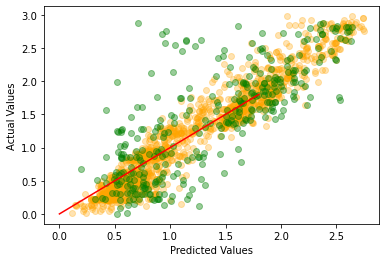

In [293]:
plt.scatter(y_train_pred, np.array(As_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(As_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 1.8], [0, 1.8], color='red', linestyle='-')

plt.show()

Cd

Optimization

In [294]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveRF(trial, Cd_X_train, Cd_y_train), n_trials=1000)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-14 18:19:19,617] A new study created in memory with name: rf_parameter_opt
[I 2023-08-14 18:19:20,446] Trial 0 finished with value: 0.5809401826079192 and parameters: {'n_estimators': 54, 'max_depth': 8, 'min_samples_leaf': 10, 'min_samples_split': 14}. Best is trial 0 with value: 0.5809401826079192.
[I 2023-08-14 18:19:20,765] Trial 1 finished with value: 0.484307355950262 and parameters: {'n_estimators': 28, 'max_depth': 4, 'min_samples_leaf': 20, 'min_samples_split': 13}. Best is trial 0 with value: 0.5809401826079192.
[I 2023-08-14 18:19:21,882] Trial 2 finished with value: 0.5692603640324869 and parameters: {'n_estimators': 74, 'max_depth': 9, 'min_samples_leaf': 13, 'min_samples_split': 3}. Best is trial 0 with value: 0.5809401826079192.
[I 2023-08-14 18:19:22,611] Trial 3 finished with value: 0.3555107494623345 and parameters: {'n_estimators': 88, 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 6}. Best is trial 0 with value: 0.5809401826079192.
[I 2023-08

Best r2:  0.6328030821456773
Best trial: {'n_estimators': 92, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 3}


In [27]:
optuna.visualization.plot_parallel_coordinate(study)

In [295]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 92, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 3}


92

In [296]:
rf_params = {
    "random_state": 42,
    #"learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    #"subsample": study.best_trial.params["subsample"]
}

rf = RandomForestRegressor(**rf_params)
rf.fit(Cd_X_train, Cd_y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=3,
                      n_estimators=92, random_state=42)

In [297]:
y_train_pred = rf.predict(Cd_X_train)
y_test_pred = rf.predict(Cd_X_test)

In [298]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Cd_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Cd_y_test, y_test_pred)))

Train RMSE:  0.08193089289286529
Test RMSE:  0.11358795543480409


In [299]:
print("Train R2: ", r2_score(Cd_y_train, y_train_pred))
print("Test R2: ", r2_score(Cd_y_test, y_test_pred))

Train R2:  0.8621306675299858
Test R2:  0.7178299990717524


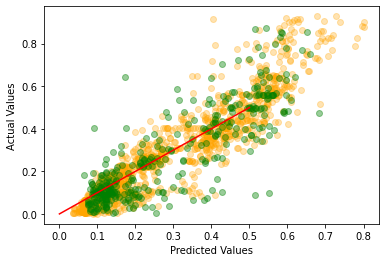

In [300]:
plt.scatter(y_train_pred, np.array(Cd_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Cd_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 0.5], [0, 0.5], color='red', linestyle='-')

plt.show()

Ni

In [301]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="rf_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveRF(trial, Ni_X_train, Ni_y_train), n_trials=1000)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-14 18:44:41,969] A new study created in memory with name: rf_parameter_opt
[I 2023-08-14 18:44:43,128] Trial 0 finished with value: 0.512824774112622 and parameters: {'n_estimators': 78, 'max_depth': 6, 'min_samples_leaf': 18, 'min_samples_split': 4}. Best is trial 0 with value: 0.512824774112622.
[I 2023-08-14 18:44:43,978] Trial 1 finished with value: 0.29630571193624433 and parameters: {'n_estimators': 92, 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 11}. Best is trial 0 with value: 0.512824774112622.
[I 2023-08-14 18:44:44,439] Trial 2 finished with value: 0.5034406281042175 and parameters: {'n_estimators': 31, 'max_depth': 6, 'min_samples_leaf': 20, 'min_samples_split': 3}. Best is trial 0 with value: 0.512824774112622.
[I 2023-08-14 18:44:45,100] Trial 3 finished with value: 0.29676769873351416 and parameters: {'n_estimators': 73, 'max_depth': 2, 'min_samples_leaf': 16, 'min_samples_split': 7}. Best is trial 0 with value: 0.512824774112622.
[I 2023-08-14

Best r2:  0.6945197387441204
Best trial: {'n_estimators': 63, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [308]:
optuna.visualization.plot_parallel_coordinate(study)

In [302]:
print("Best trial:", study.best_trial.params)
study.best_trial.params["n_estimators"]

Best trial: {'n_estimators': 63, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


63

In [303]:
rf_params = {
    "random_state": 42,
    #"learning_rate": 0.1,
    "n_estimators": study.best_trial.params["n_estimators"],
    "max_depth": study.best_trial.params["max_depth"],
    "min_samples_leaf": study.best_trial.params["min_samples_leaf"],
    "min_samples_split": study.best_trial.params["min_samples_split"],
    #"subsample": study.best_trial.params["subsample"]
}

rf = RandomForestRegressor(**rf_params)
rf.fit(Ni_X_train, Ni_y_train)

RandomForestRegressor(max_depth=10, n_estimators=63, random_state=42)

In [304]:
y_train_pred = rf.predict(Ni_X_train)
y_test_pred = rf.predict(Ni_X_test)

In [305]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Ni_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Ni_y_test, y_test_pred)))

Train RMSE:  0.32411594759917367
Test RMSE:  0.6507055821471858


In [306]:
print("Train R2: ", r2_score(Ni_y_train, y_train_pred))
print("Test R2: ", r2_score(Ni_y_test, y_test_pred))

Train R2:  0.9268737479390716
Test R2:  0.7042437605236751


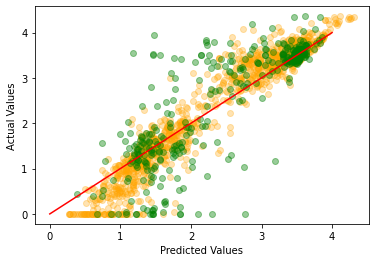

In [307]:
plt.scatter(y_train_pred, np.array(Ni_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Ni_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4.0], [0, 4.0], color='red', linestyle='-')

plt.show()